---

Швецов Д.А. ИСУ: 285659

---

#Лаб. 7. Proximal policy optimization

##Сетап

In [1]:
# !sudo apt-get update
# !sudo apt-get install -y xvfb python3-opengl
# !pip install pyvirtualdisplay
# !pip install gym[classic_control]

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
# from pyvirtualdisplay import Display
# d = Display(visible=0, size=(400, 300))
# d.start()

def show_state(env, episode=0, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())#mode='rgb_array'))
    plt.title("%s | Eposide: %d | Step: %d %s" % ('Cart-pole-v1', episode, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [3]:
# import copy
import torch
from torch import distributions
# from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
# import random
# import math
# import torchvision.transforms as T
import numpy as np
# import time
# import gym, math
import gymnasium as gym
from scipy.signal import lfilter

##Классы и функции

Честно взято отсюда: https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ppo/core.py

In [4]:
# Чтобы не прописывать все слои сети руками
def mlp(sizes, activation, output_activation=torch.nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [torch.nn.Linear(sizes[j], sizes[j+1]), act()]
    return torch.nn.Sequential(*layers)

# Для подсчета массива ожидаемых суммарных
# вознаграждений с дисконтированием по массиву наград
def discount_cumsum(x, discount):
  return lfilter(
      b=[1],
      a=[1, float(-discount)],
      x=x[::-1],
      axis=0)[::-1]

# Агент, который еще только учится
class MLPCategoricalActor(torch.nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.logits_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def get_policy(self, obs):
        logits = self.logits_net(obs)
        return distributions.Categorical(logits=logits)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act)

    def forward(self, obs, act=None):
        # Produce action distributions for given observations, and
        # optionally compute the log likelihood of given actions under
        # those distributions.
        pi = self.get_policy(obs)
        logp_a = None
        if act is not None:
            logp_a = self._log_prob_from_distribution(pi, act)
        return pi, logp_a

# Начинающий оценщик V-функции
class MLPCritic(torch.nn.Module):

    def __init__(self, obs_dim, hidden_sizes, activation):
        super().__init__()
        self.v_net = mlp([obs_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs):
        return torch.squeeze(self.v_net(obs), -1) # Critical to ensure v has right shape.

In [5]:
class PPOac(torch.nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=12, pi_lr=3e-4, vf_lr=1e-3, train_pi_iters=5, train_v_iters=5, target_kl=0.01, clip_ratio=0.2):
        super().__init__()

        activation = torch.nn.Tanh
        # activation = torch.nn.LeakyReLU()
        hidden_sizes = [hidden_dim] * 1
        self.pi = MLPCategoricalActor(state_dim, action_dim, hidden_sizes, activation)

        # build value function
        self.v  = MLPCritic(state_dim, hidden_sizes, activation)

        self.pi_optimizer = torch.optim.Adam(self.pi.parameters(), lr=pi_lr)
        self.vf_optimizer = torch.optim.Adam(self.v.parameters(), lr=vf_lr)
        self.train_pi_iters = train_pi_iters
        self.train_v_iters = train_v_iters
        self.target_kl = target_kl
        self.clip_ratio = clip_ratio

    def get_action(self, state):
        with torch.no_grad():
            obs = torch.as_tensor(state, dtype=torch.float32)
            pi = self.pi.get_policy(obs)
            a = pi.sample()
            logp_a = self.pi._log_prob_from_distribution(pi, a)
            v = self.v(obs)
        return a.numpy(), v.numpy(), logp_a.numpy()

    # def act(self, obs):
        #     return self.step(obs)[0]

    # Set up function for computing PPO policy loss
    def compute_loss_pi(self, obs, act, adv, logp_old):
        # obs, act, adv, logp_old = data['obs'], data['act'], data['adv'], data['logp']

        # Policy loss
        pi, logp = self.pi(obs, act)
        ratio = torch.exp(logp - logp_old)
        clip_adv = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * adv
        loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()

        # # Useful extra info
        # approx_kl = (logp_old - logp).mean().item()
        # ent = pi.entropy().mean().item()
        # clipped = ratio.gt(1 + clip_ratio) | ratio.lt(1 - clip_ratio)
        # clipfrac = torch.as_tensor(clipped, dtype=torch.float32).mean().item()
        # pi_info = dict(kl=approx_kl, ent=ent, cf=clipfrac)

        approx_kl = (logp_old - logp).mean().item()
        pi_info = dict(kl=approx_kl)

        return loss_pi, pi_info

    # Set up function for computing value loss
    def compute_loss_v(self, obs, ret):
        # obs, ret = data['obs'], data['ret']
        return ((self.v(obs) - ret) ** 2).mean()

    def update(self, obs, batch_actions, adv, logp_old, ret):
        # data = buf.get()
        obs = torch.as_tensor(obs, dtype=torch.float32)
        act = torch.as_tensor(batch_actions, dtype=torch.float32)
        # torch.FloatTensor(
        adv = torch.as_tensor(adv, dtype=torch.float32)
        logp_old = torch.as_tensor(logp_old, dtype=torch.float32)
        ret = torch.as_tensor(ret, dtype=torch.float32)


        pi_l_old, pi_info_old = self.compute_loss_pi(obs, act, adv, logp_old)
        pi_l_old = pi_l_old.item()
        v_l_old = self.compute_loss_v(obs, ret).item()

        # Train policy with multiple steps of gradient descent
        for i in range(self.train_pi_iters):
            self.pi_optimizer.zero_grad()
            loss_pi, pi_info = self.compute_loss_pi(obs, act, adv, logp_old)
            # kl = mpi_avg(pi_info['kl'])
            kl = pi_info['kl']
            if kl > 1.5 * self.target_kl:
                # logger.log('Early stopping at step %d due to reaching max kl.' % i)
                break
            loss_pi.backward()
            # mpi_avg_grads(ac.pi)  # average grads across MPI processes
            self.pi_optimizer.step()

        # logger.store(StopIter=i)

        # Value function learning
        for i in range(self.train_v_iters):
            self.vf_optimizer.zero_grad()
            loss_v = self.compute_loss_v(obs, ret)
            loss_v.backward()
            # mpi_avg_grads(ac.v)  # average grads across MPI processes
            self.vf_optimizer.step()

        # Log changes from update
        # kl, ent, cf = pi_info['kl'], pi_info_old['ent'], pi_info['cf']
        # logger.store(LossPi=pi_l_old, LossV=v_l_old,
        #               KL=kl, Entropy=ent, ClipFrac=cf,
        #               DeltaLossPi=(loss_pi.item() - pi_l_old),
        #               DeltaLossV=(loss_v.item() - v_l_old))

##Обучение
Успешно обучилось 4 раза из 7. 3 раза из 7 либо вообще не обучилось, либо есть пара просадок на валидации


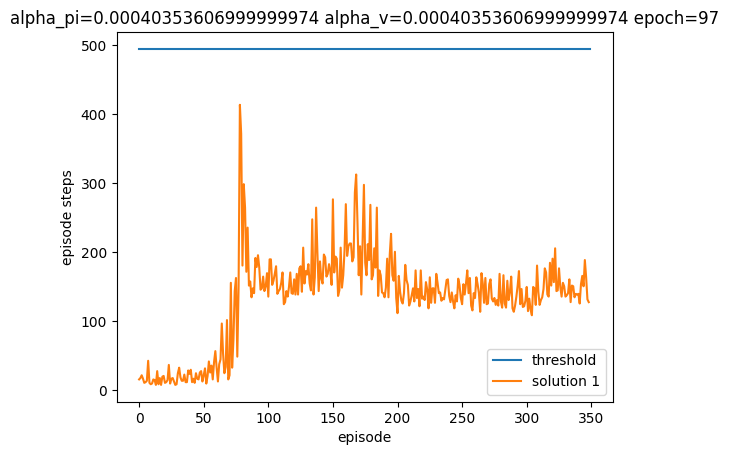

done


In [7]:

device = "cpu"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('CartPole-v1', render_mode='rgb_array')
# env = gym.make('CartPole-v1')
print('SHApes',env.observation_space.shape, env.action_space.shape)


#PPO

# Learning Parameters
alpha_pi = 0.01
alpha_v = 0.01
gsteps_pi = 20
gsteps_v = 20
gamma=0.99
lam = 0.95 # ЭТО lambda ДЛЯ ADVANTAGE

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 350
STEPS_MAX = 500
DESIRED_STEPS = 250

# Loggers
log_steps_number = np.zeros(EPISODES_MAX)

n_states = 4
n_actions = 2
n_hidden = 10

agent = PPOac(n_states, n_actions, n_hidden, alpha_pi, alpha_v, gsteps_pi, gsteps_v)
scheduler_pi = StepLR(agent.pi_optimizer, step_size=10, gamma=0.7)
scheduler_v = StepLR(agent.vf_optimizer, step_size=10, gamma=0.7)

#data storage
batch_size = 400

batch_states = []
batch_actions = []
batch_ret = []
batch_adv = []
batch_logps = []

epoch = 0

# PPO
for i_episode in range(EPISODES_MAX):
    episode_states = []
    episode_actions = []
    episode_rewards = []
    # episode_total_return = 0
    episode_logps = []
    episode_vals = []
    episode_ret = []

    observation = env.reset()[0]
    state = observation

    # show results
    if (i_episode + 1) % 10 == 0:
        plt.figure(1)
        plt.clf()
        plt.plot([0,i_episode], [495, 495], label="threshold")
        plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode steps')
        plt.legend()
        plt.title('alpha_pi={} alpha_v={} epoch={}'.format(scheduler_pi.get_last_lr()[0],scheduler_v.get_last_lr()[0],epoch))
        display.clear_output(wait=True)
        plt.show()

    for t in range(STEPS_MAX):
        action, v, logp = agent.get_action(state)
        # print(action,v,logp)
        action = action.tolist()
        logp = logp.tolist()

        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # episode_total_return += reward
        episode_states.append(state)
        episode_actions.append(action)
        episode_rewards.append(reward)
        episode_logps.append(logp)
        episode_vals.append(v)

        state = observation

        if done:
            log_steps_number[i_episode] = t;

            last_val = 0
            episode_ended = t == STEPS_MAX - 1
            if episode_ended:
              _, last_val, _ = agent.get_action(state)
            rews = np.append(episode_rewards, last_val)
            vals = np.append(episode_vals, last_val)
            # the next two lines implement GAE-Lambda advantage calculation
            deltas = rews[:-1] + gamma * vals[1:] - vals[:-1]
            episode_adv = discount_cumsum(deltas, gamma * lam).tolist()
            # the next line computes rewards-to-go, to be targets for the value function
            episode_ret = discount_cumsum(rews, gamma)[:-1].tolist()

            batch_states += episode_states
            batch_actions += episode_actions
            batch_logps += episode_logps
            batch_adv += episode_adv
            batch_ret += episode_ret


            if len(batch_states) >= batch_size:
              agent.update(batch_states, batch_actions, batch_adv, batch_logps, batch_ret)

              epoch += 1
              batch_states = []
              batch_actions = []
              batch_logps = []
              batch_adv = []
              batch_ret = []

              scheduler_pi.step()
              scheduler_v.step()

            break

print("done")

##Проверка

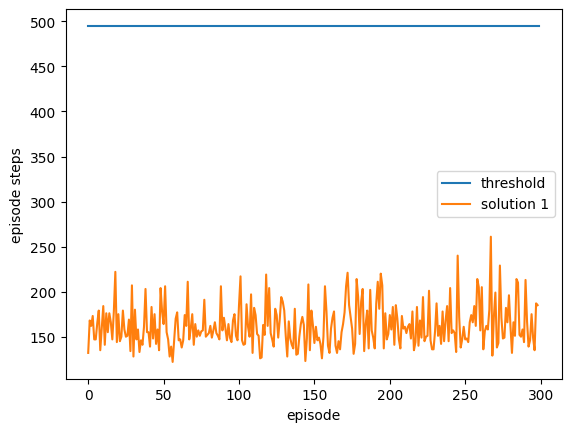

done


In [8]:
# env = gym.make('CartPole-v1')
env = gym.make('CartPole-v1', render_mode='rgb_array')

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 300
STEPS_MAX = 500

# Loggers
log_steps_number = np.zeros(EPISODES_MAX)

# PQ
for i_episode in range(EPISODES_MAX):
    observation = env.reset()[0]
    state = observation

    # show results
    if (i_episode + 1) % 20 == 0:
        plt.figure(1)
        plt.clf()
        plt.plot([0,i_episode], [495, 495], label="threshold")
        plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode steps')
        plt.legend()
        display.clear_output(wait=True)
        plt.show()

    for t in range(STEPS_MAX):
        action, _, _ = agent.get_action(state)
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = observation

        if done:
            log_steps_number[i_episode] = t;
            break

print("done")